In [1]:
"""
@author: Maziar Raissi
"""

import sys
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(1234)
tf.set_random_seed(1234)

In [11]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        
        self.lb = lb
        self.ub = ub
    
        self.x_u = X_u[:,0:1]
        self.t_u = X_u[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u = u
        
        self.layers = layers
        self.nu = nu
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_u_tf = tf.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])
        self.t_u_tf = tf.placeholder(tf.float32, shape=[None, self.t_u.shape[1]])        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])        
                
        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf) 
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)         
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
               
                
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        self.eval_ = {'cost':[]}
        self.index = {'index': []}
                
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x,t):
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_t + u*u_x - self.nu*u_xx
        
        return f
    
    def callback(self, loss):
        self.eval_['cost'].append(loss)
        print('Loss:', loss)
        
    def train(self):
        
        tf_dict = {self.x_u_tf: self.x_u, self.t_u_tf: self.t_u, self.u_tf: self.u,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
                
        u_star = self.sess.run(self.u_pred, {self.x_u_tf: X_star[:,0:1], self.t_u_tf: X_star[:,1:2]})  
        f_star = self.sess.run(self.f_pred, {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]})
               
        return u_star, f_star

Loss: 0.027766367
Loss: 1.0744218
Loss: 0.025212226
Loss: 0.02296518
Loss: 0.022312945
Loss: 0.0222618
Loss: 0.022255184
Loss: 0.022243364
Loss: 0.02218333
Loss: 0.02209199
Loss: 0.0219534
Loss: 0.021923743
Loss: 0.021917727
Loss: 0.021915384
Loss: 0.021912627
Loss: 0.02190905
Loss: 0.021904562
Loss: 0.021897152
Loss: 0.021887146
Loss: 0.021860162
Loss: 0.021796346
Loss: 0.021733245
Loss: 0.022114534
Loss: 0.021682967
Loss: 0.021933956
Loss: 0.02154381
Loss: 0.021529038
Loss: 0.021496251
Loss: 0.021426935
Loss: 0.021377238
Loss: 0.021347906
Loss: 0.021326788
Loss: 0.021207858
Loss: 0.021284284
Loss: 0.02116753
Loss: 0.021160051
Loss: 0.021145325
Loss: 0.021128623
Loss: 0.02111308
Loss: 0.021100746
Loss: 0.021077469
Loss: 0.021051465
Loss: 0.021034922
Loss: 0.021024907
Loss: 0.021016104
Loss: 0.02100985
Loss: 0.021004042
Loss: 0.021000382
Loss: 0.02099823
Loss: 0.02099716
Loss: 0.020996816
Loss: 0.020996511
Loss: 0.020995865
Loss: 0.020994486
Loss: 0.02099123
Loss: 0.020983914
Loss: 0.0

Loss: 0.0042046355
Loss: 0.0042028213
Loss: 0.004201991
Loss: 0.0041991444
Loss: 0.0041962126
Loss: 0.0041908114
Loss: 0.0041816295
Loss: 0.0041686906
Loss: 0.004280924
Loss: 0.004164828
Loss: 0.004150971
Loss: 0.004143698
Loss: 0.0041408534
Loss: 0.004138921
Loss: 0.004136936
Loss: 0.00413406
Loss: 0.004131964
Loss: 0.004129633
Loss: 0.004127259
Loss: 0.0041260873
Loss: 0.0041223904
Loss: 0.0041190204
Loss: 0.0041162074
Loss: 0.004111223
Loss: 0.0041074506
Loss: 0.0041028843
Loss: 0.0040946766
Loss: 0.0040842807
Loss: 0.0040723784
Loss: 0.004054762
Loss: 0.0040467787
Loss: 0.0040320037
Loss: 0.0040259403
Loss: 0.0040163007
Loss: 0.004003633
Loss: 0.0039985017
Loss: 0.0039959745
Loss: 0.003993476
Loss: 0.0039913706
Loss: 0.0039882944
Loss: 0.0039862525
Loss: 0.0039835717
Loss: 0.0039824597
Loss: 0.0039818566
Loss: 0.003980659
Loss: 0.003978001
Loss: 0.0039721946
Loss: 0.00396214
Loss: 0.0039909366
Loss: 0.003956486
Loss: 0.0039392137
Loss: 0.0039299135
Loss: 0.0039207884
Loss: 0.003916

Loss: 0.00043919636
Loss: 0.0004349494
Loss: 0.0004318073
Loss: 0.00042688954
Loss: 0.0004235545
Loss: 0.00042014013
Loss: 0.00041500304
Loss: 0.000410542
Loss: 0.00040702426
Loss: 0.00040440666
Loss: 0.00040317967
Loss: 0.00040187425
Loss: 0.00040113006
Loss: 0.0004003846
Loss: 0.00039948916
Loss: 0.00039866744
Loss: 0.00039821258
Loss: 0.00039706612
Loss: 0.00039624766
Loss: 0.000394897
Loss: 0.00039318998
Loss: 0.00039110574
Loss: 0.00038936592
Loss: 0.00038773054
Loss: 0.00038580428
Loss: 0.00038338586
Loss: 0.0003811242
Loss: 0.0003779612
Loss: 0.0003747851
Loss: 0.0003817775
Loss: 0.00037338777
Loss: 0.00037112355
Loss: 0.00036892516
Loss: 0.00036843595
Loss: 0.00036762288
Loss: 0.00036709127
Loss: 0.00036631056
Loss: 0.00036559106
Loss: 0.00036470243
Loss: 0.00036379433
Loss: 0.00036276068
Loss: 0.00036189007
Loss: 0.00036046735
Loss: 0.00035872892
Loss: 0.00035644413
Loss: 0.00035397458
Loss: 0.00035077689
Loss: 0.0003469398
Loss: 0.0003437287
Loss: 0.00034173555
Loss: 0.000339

Loss: 0.00012670562
Loss: 0.00012648507
Loss: 0.00012621348
Loss: 0.00012580474
Loss: 0.0001252603
Loss: 0.00012467385
Loss: 0.00012383086
Loss: 0.00012337044
Loss: 0.00012297597
Loss: 0.00012257714
Loss: 0.00012220713
Loss: 0.000121852194
Loss: 0.00012140231
Loss: 0.00012109864
Loss: 0.000120753626
Loss: 0.00012041119
Loss: 0.000120012395
Loss: 0.00011954762
Loss: 0.00011895997
Loss: 0.00011848808
Loss: 0.0001180111
Loss: 0.00011756719
Loss: 0.000116998315
Loss: 0.000116257565
Loss: 0.00011553273
Loss: 0.00011468082
Loss: 0.00011398541
Loss: 0.00011348365
Loss: 0.000113003305
Loss: 0.00011210362
Loss: 0.00011112721
Loss: 0.000110181674
Loss: 0.00010930844
Loss: 0.00010855058
Loss: 0.00010783974
Loss: 0.000106932406
Loss: 0.00010647107
Loss: 0.00010590347
Loss: 0.000106518535
Loss: 0.000105687745
Loss: 0.00010543843
Loss: 0.00010527835
Loss: 0.000105148225
Loss: 0.00010490959
Loss: 0.000104683946
Loss: 0.000105006606
Loss: 0.00010451932
Loss: 0.00010431529
Loss: 0.00010415376
Loss: 0.0

Loss: 4.5949986e-05
Loss: 4.591185e-05
Loss: 4.585372e-05
Loss: 4.57421e-05
Loss: 4.5828412e-05
Loss: 4.568701e-05
Loss: 4.5603505e-05
Loss: 4.5553188e-05
Loss: 4.5518875e-05
Loss: 4.5426925e-05
Loss: 4.5329863e-05
Loss: 4.51572e-05
Loss: 4.4949335e-05
Loss: 4.464497e-05
Loss: 4.4391152e-05
Loss: 4.410207e-05
Loss: 4.3916785e-05
Loss: 4.3724278e-05
Loss: 4.360598e-05
Loss: 4.3486747e-05
Loss: 4.3257292e-05
Loss: 4.3157237e-05
Loss: 4.291264e-05
Loss: 4.2794585e-05
Loss: 4.261636e-05
Loss: 4.2525768e-05
Loss: 4.2428765e-05
Loss: 4.2298852e-05
Loss: 4.2262014e-05
Loss: 4.221834e-05
Loss: 4.216835e-05
Loss: 4.2075262e-05
Loss: 4.1981588e-05
Loss: 4.1865875e-05
Loss: 4.1759507e-05
Loss: 4.1693696e-05
Loss: 4.1620122e-05
Loss: 4.157684e-05
Loss: 4.147968e-05
Loss: 4.1364605e-05
Loss: 4.123884e-05
Loss: 4.139275e-05
Loss: 4.119663e-05
Loss: 4.1085135e-05
Loss: 4.1017076e-05
Loss: 4.0934323e-05
Loss: 4.085807e-05
Loss: 4.0774692e-05
Loss: 4.0693463e-05
Loss: 4.0604085e-05
Loss: 4.0509418e-05


Loss: 2.4429988e-05
Loss: 2.4377556e-05
Loss: 2.434417e-05
Loss: 2.433385e-05
Loss: 2.4308607e-05
Loss: 2.4301291e-05
Loss: 2.4283456e-05
Loss: 2.4367944e-05
Loss: 2.4269333e-05
Loss: 2.4249171e-05
Loss: 2.4219395e-05
Loss: 2.4199435e-05
Loss: 2.4184474e-05
Loss: 2.4136443e-05
Loss: 2.4121013e-05
Loss: 2.4330187e-05
Loss: 2.4111805e-05
Loss: 2.4092224e-05
Loss: 2.4080573e-05
Loss: 2.4063987e-05
Loss: 2.4050329e-05
Loss: 2.4044914e-05
Loss: 2.4031498e-05
Loss: 2.4016652e-05
Loss: 2.3995082e-05
Loss: 2.3965895e-05
Loss: 2.3936096e-05
Loss: 2.3905224e-05
Loss: 2.3877301e-05
Loss: 2.382372e-05
Loss: 2.3814748e-05
Loss: 2.3729648e-05
Loss: 2.3698612e-05
Loss: 2.3672714e-05
Loss: 2.3643783e-05
Loss: 2.3611283e-05
Loss: 2.3564802e-05
Loss: 2.3547442e-05
Loss: 2.352169e-05
Loss: 2.3491672e-05
Loss: 2.3500585e-05
Loss: 2.347091e-05
Loss: 2.3423467e-05
Loss: 2.3366143e-05
Loss: 2.329217e-05
Loss: 2.321613e-05
Loss: 2.3097238e-05
Loss: 2.322725e-05
Loss: 2.3057108e-05
Loss: 2.2996916e-05
Loss: 2.

Loss: 1.6169646e-05
Loss: 1.6160577e-05
Loss: 1.6153626e-05
Loss: 1.6147551e-05
Loss: 1.6135727e-05
Loss: 1.6227708e-05
Loss: 1.6121061e-05
Loss: 1.6103711e-05
Loss: 1.6074686e-05
Loss: 1.6065911e-05
Loss: 1.603576e-05
Loss: 1.6020942e-05
Loss: 1.6030492e-05
Loss: 1.6012433e-05
Loss: 1.6005895e-05
Loss: 1.5999378e-05
Loss: 1.5994481e-05
Loss: 1.5982612e-05
Loss: 1.596604e-05
Loss: 1.5999865e-05
Loss: 1.5954247e-05
Loss: 1.593453e-05
Loss: 1.5918664e-05
Loss: 1.602023e-05
Loss: 1.5915166e-05
Loss: 1.5902471e-05
Loss: 1.5889833e-05
Loss: 1.5878195e-05
Loss: 1.5870417e-05
Loss: 1.5861502e-05
Loss: 1.5851958e-05
Loss: 1.5838386e-05
Loss: 1.5823909e-05
Loss: 1.581526e-05
Loss: 1.581146e-05
Loss: 1.580636e-05
Loss: 1.579894e-05
Loss: 1.5789245e-05
Loss: 1.5788648e-05
Loss: 1.5783571e-05
Loss: 1.57728e-05
Loss: 1.576614e-05
Loss: 1.575904e-05
Loss: 1.575423e-05
Loss: 1.5752557e-05
Loss: 1.5749141e-05
Loss: 1.574653e-05
Loss: 1.5741069e-05
Loss: 1.5733029e-05
Loss: 1.579358e-05
Loss: 1.5730666

Loss: 1.0949721e-05
Loss: 1.0975985e-05
Loss: 1.0947388e-05
Loss: 1.0941454e-05
Loss: 1.0933146e-05
Loss: 1.0925344e-05
Loss: 1.0918425e-05
Loss: 1.0914604e-05
Loss: 1.09092025e-05
Loss: 1.0905018e-05
Loss: 1.0897627e-05
Loss: 1.0889911e-05
Loss: 1.0878061e-05
Loss: 1.086746e-05
Loss: 1.0859074e-05
Loss: 1.0844678e-05
Loss: 1.0811958e-05
Loss: 1.0782596e-05
Loss: 1.075066e-05
Loss: 1.0739872e-05
Loss: 1.0728074e-05
Loss: 1.07222495e-05
Loss: 1.0711885e-05
Loss: 1.0701258e-05
Loss: 1.0691412e-05
Loss: 1.0682321e-05
Loss: 1.067238e-05
Loss: 1.0666972e-05
Loss: 1.0661904e-05
Loss: 1.065773e-05
Loss: 1.0654094e-05
Loss: 1.0646645e-05
Loss: 1.0638078e-05
Loss: 1.0632e-05
Loss: 1.0652933e-05
Loss: 1.0628561e-05
Loss: 1.0624144e-05
Loss: 1.0615124e-05
Loss: 1.0609375e-05
Loss: 1.0598732e-05
Loss: 1.0604106e-05
Loss: 1.0593814e-05
Loss: 1.058592e-05
Loss: 1.0574828e-05
Loss: 1.0568042e-05
Loss: 1.05559875e-05
Loss: 1.0563687e-05
Loss: 1.0550424e-05
Loss: 1.0544148e-05
Loss: 1.0533774e-05
Loss:

Loss: 7.5047546e-06
Loss: 7.5011762e-06
Loss: 7.4983514e-06
Loss: 7.495966e-06
Loss: 7.4884983e-06
Loss: 7.573407e-06
Loss: 7.487456e-06
Loss: 7.4822206e-06
Loss: 7.476565e-06
Loss: 7.472028e-06
Loss: 7.4661966e-06
Loss: 7.462547e-06
Loss: 7.4569652e-06
Loss: 7.4533705e-06
Loss: 7.4496515e-06
Loss: 7.4451355e-06
Loss: 7.440904e-06
Loss: 7.4357686e-06
Loss: 7.430661e-06
Loss: 7.4212244e-06
Loss: 7.418607e-06
Loss: 7.4145332e-06
Loss: 7.409e-06
Loss: 7.4012723e-06
Loss: 7.3979872e-06
Loss: 7.3872825e-06
Loss: 7.3828005e-06
Loss: 7.376442e-06
Loss: 7.3700394e-06
Loss: 7.361149e-06
Loss: 7.351372e-06
Loss: 7.3349374e-06
Loss: 7.3274214e-06
Loss: 7.323829e-06
Loss: 7.318562e-06
Loss: 7.315325e-06
Loss: 7.3089236e-06
Loss: 7.3058604e-06
Loss: 7.2975404e-06
Loss: 7.285811e-06
Loss: 7.383234e-06
Loss: 7.283553e-06
Loss: 7.275769e-06
Loss: 7.271361e-06
Loss: 7.274894e-06
Loss: 7.269167e-06
Loss: 7.2659104e-06
Loss: 7.2641938e-06
Loss: 7.2618163e-06
Loss: 7.2591984e-06
Loss: 7.256284e-06
Loss: 7

Loss: 5.7773377e-06
Loss: 5.77827e-06
Loss: 5.7761035e-06
Loss: 5.7750613e-06
Loss: 5.7743264e-06
Loss: 5.772318e-06
Loss: 5.771557e-06
Loss: 5.7703833e-06
Loss: 5.7691714e-06
Loss: 5.768312e-06
Loss: 5.767097e-06
Loss: 5.765135e-06
Loss: 5.7623092e-06
Loss: 5.760712e-06
Loss: 5.759246e-06
Loss: 5.7600655e-06
Loss: 5.757512e-06
Loss: 5.7563057e-06
Loss: 5.753967e-06
Loss: 5.7515567e-06
Loss: 5.7492152e-06
Loss: 5.747017e-06
Loss: 5.745736e-06
Loss: 5.744251e-06
Loss: 5.7422985e-06
Loss: 5.7388793e-06
Loss: 5.735554e-06
Loss: 5.733987e-06
Loss: 5.7313277e-06
Loss: 5.753639e-06
Loss: 5.7302177e-06
Loss: 5.7294137e-06
Loss: 5.7286393e-06
Loss: 5.727238e-06
Loss: 5.7254874e-06
Loss: 5.7242187e-06
Loss: 5.7205534e-06
Loss: 5.715623e-06
Loss: 5.7112343e-06
Loss: 5.7084003e-06
Loss: 5.720747e-06
Loss: 5.7073244e-06
Loss: 5.7054485e-06
Loss: 5.702114e-06
Loss: 5.699454e-06
Loss: 5.6971758e-06
Loss: 5.696349e-06
Loss: 5.6944596e-06
Loss: 5.6925783e-06
Loss: 5.6946787e-06
Loss: 5.69126e-06
Loss:

Loss: 4.9467553e-06
Loss: 4.944819e-06
Loss: 4.943843e-06
Loss: 4.9430737e-06
Loss: 4.9411483e-06
Loss: 4.9399855e-06
Loss: 4.938197e-06
Loss: 4.9353775e-06
Loss: 4.932083e-06
Loss: 4.9541713e-06
Loss: 4.9308655e-06
Loss: 4.9277814e-06
Loss: 4.9244923e-06
Loss: 4.920611e-06
Loss: 4.9153887e-06
Loss: 4.910339e-06
Loss: 4.9075866e-06
Loss: 4.9024407e-06
Loss: 4.8981356e-06
Loss: 4.8959446e-06
Loss: 4.893168e-06
Loss: 4.8910665e-06
Loss: 4.8886354e-06
Loss: 4.8856923e-06
Loss: 4.883076e-06
Loss: 4.881287e-06
Loss: 4.879743e-06
Loss: 4.8779393e-06
Loss: 4.876208e-06
Loss: 4.8727834e-06
Loss: 4.870764e-06
Loss: 4.869528e-06
Loss: 4.868264e-06
Loss: 4.866677e-06
Loss: 4.8637835e-06
Loss: 4.862339e-06
Loss: 4.860037e-06
Loss: 4.8590705e-06
Loss: 4.8565566e-06
Loss: 4.8545303e-06
Loss: 4.853226e-06
Loss: 4.8515735e-06
Loss: 4.8493766e-06
Loss: 4.8474053e-06
Loss: 4.8428215e-06
Loss: 4.838338e-06
Loss: 4.835075e-06
Loss: 4.8537654e-06
Loss: 4.8336337e-06
Loss: 4.8300817e-06
Loss: 4.8272796e-06


Loss: 4.1634207e-06
Loss: 4.160165e-06
Loss: 4.157876e-06
Loss: 4.1562344e-06
Loss: 4.1543776e-06
Loss: 4.151464e-06
Loss: 4.1484896e-06
Loss: 4.152463e-06
Loss: 4.1463827e-06
Loss: 4.140134e-06
Loss: 4.132265e-06
Loss: 4.1242065e-06
Loss: 4.1501953e-06
Loss: 4.1218937e-06
Loss: 4.1173435e-06
Loss: 4.1100943e-06
Loss: 4.106882e-06
Loss: 4.104024e-06
Loss: 4.0990435e-06
Loss: 4.096639e-06
Loss: 4.0941864e-06
Loss: 4.0915397e-06
Loss: 4.090126e-06
Loss: 4.0875316e-06
Loss: 4.085182e-06
Loss: 4.0827945e-06
Loss: 4.0805485e-06
Loss: 4.077538e-06
Loss: 4.074757e-06
Loss: 4.072999e-06
Loss: 4.0715754e-06
Loss: 4.069139e-06
Loss: 4.0672207e-06
Loss: 4.064419e-06
Loss: 4.060307e-06
Loss: 4.0564273e-06
Loss: 4.050142e-06
Loss: 4.0441746e-06
Loss: 4.0396453e-06
Loss: 4.034897e-06
Loss: 4.0323575e-06
Loss: 4.0308814e-06
Loss: 4.0300747e-06
Loss: 4.0288546e-06
Loss: 4.02789e-06
Loss: 4.0259774e-06
Loss: 4.0245313e-06
Loss: 4.022855e-06
Loss: 4.030986e-06
Loss: 4.0220566e-06
Loss: 4.018385e-06
Loss

Loss: 3.4752852e-06
Loss: 3.4752852e-06
Loss: 3.4753975e-06
Loss: 3.4752852e-06
Loss: 3.4752852e-06
Loss: 3.4754162e-06
Loss: 3.4752852e-06
Loss: 3.4752852e-06
Loss: 3.475432e-06
Loss: 3.4752852e-06
Loss: 3.4752852e-06
Loss: 3.475343e-06
Loss: 3.4752852e-06
Loss: 3.4752852e-06
Loss: 3.4752852e-06
Training time: 667.8828
Error u: 3.031867e-02


RuntimeError: The command
    ['latex', '-interaction=nonstopmode', '"C:/Users/702-user/AppData/Local/Temp/tmpo7xo4yds/tmp.ps.tex"']
failed and generated the following output:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (MiKTeX 2.9)
entering extended mode
(C:/Users/702-user/AppData/Local/Temp/tmpo7xo4yds/tmp.ps.tex
LaTeX2e <2014/05/01>
Babel <3.9l> and hyphenation patterns for 68 languages loaded.
("C:\Program Files (x86)\MiKTeX 2.9\tex\latex\base\article.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
("C:\Program Files (x86)\MiKTeX 2.9\tex\latex\base\size10.clo"))
("C:\Program Files (x86)\MiKTeX 2.9\tex\latex\type1cm\type1cm.sty")
("C:\Program Files (x86)\MiKTeX 2.9\tex\latex\base\textcomp.sty"
("C:\Program Files (x86)\MiKTeX 2.9\tex\latex\base\ts1enc.def"))
======================================================================
latex: Try Again
latex: Data: get host by name failed in tcp_connect()
======================================================================


! LaTeX Error: File `ucs.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               [utf8x]{inputenc}
No pages of output.
Transcript written on tmp.ps.log.


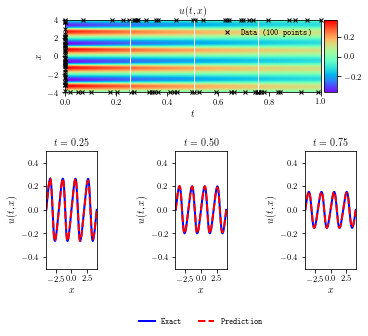

In [30]:
if __name__ == "__main__": 
     
    nu = 0.10  # 0.01/np.pi
    noise = 0.0        

    N_u = 100
    N_f = 10000
    layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
    
    data = scipy.io.loadmat('../Data/burgers_sine_0.1_TFP.mat')
    
    t = data['t'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    Exact = np.real(data['Utfp3'])
    
    X, T = np.meshgrid(x,t)
    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact.flatten()[:,None]              

    # Doman bounds
    lb = X_star.min(0)
    ub = X_star.max(0)    
        
    xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
    uu1 = Exact[0:1,:].T
    xx2 = np.hstack((X[:,0:1], T[:,0:1]))
    uu2 = Exact[:,0:1]
    xx3 = np.hstack((X[:,-1:], T[:,-1:]))
    uu3 = Exact[:,-1:]
    
    X_u_train = np.vstack([xx1, xx2, xx3])
    X_f_train = lb + (ub-lb)*lhs(2, N_f)
    X_f_train = np.vstack((X_f_train, X_u_train))
    u_train = np.vstack([uu1, uu2, uu3])
    
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    X_u_train = X_u_train[idx, :]
    u_train = u_train[idx,:]
        
    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)
    
    start_time = time.time()                
    model.train()
    elapsed = time.time() - start_time                
    print('Training time: %.4f' % (elapsed))
    
    u_pred, f_pred = model.predict(X_star)
            
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    print('Error u: %e' % (error_u))                     

    
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    Error = np.abs(Exact - U_pred)
    
    
    ######################################################################
    ############################# Plotting ###############################
    ######################################################################    
    
    fig, ax = newfig(1.0, 1.1)
    ax.axis('off')
    
    ####### Row 0: u(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                  extent=[t.min(), t.max(), x.min(), x.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)
    
    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[51]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[101]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[151]*np.ones((2,1)), line, 'w-', linewidth = 1)    
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(t,x)$', fontsize = 10)
    
    ####### Row 1: u(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/1.8, bottom=0, left=0.1, right=0.9, wspace=1.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact[51,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[51,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = 0.25$', fontsize = 10)
    #ax.axis('square')
    ax.axis([-4.1, 4.1, -0.5,0.5])
    #ax.set_xlim([-0.005,0.005])
    #ax.set_ylim([-0.005,0.005])
    
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact[101,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[101,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    #ax.axis('square')
    ax.axis([-4.1, 4.1, -0.5,0.5])
    #ax.set_xlim([-0.005,0.005])
    #ax.set_ylim([-0.005,0.005])
    ax.set_title('$t = 0.50$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
    
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact[151,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[151,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    #ax.axis('square')
    ax.axis([-4.1, 4.1, -0.5,0.5])
    #ax.set_xlim([-0.005,0.005])
    #ax.set_ylim([-0.005,0.005])    
    ax.set_title('$t = 0.75$', fontsize = 10)
    
    savefig('./figures/My_Burgers_sin_0.1_TFP')

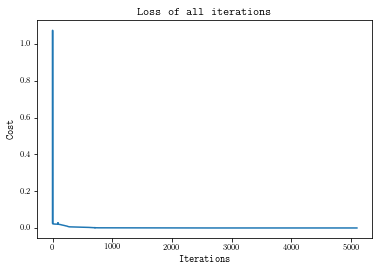

<Figure size 720x360 with 0 Axes>

In [32]:
plt.plot(range(5099), model.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.title('Loss of all iterations')
fig = plt.figure(figsize=(10,5))
fig.savefig('Loss of all iterations.jpg', bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
help(tf.truncated_normal)

In [ ]:
help(griddata)

In [ ]:
print(t.size)

In [ ]:
print(x.size)

In [ ]:
print(np.data(['Utfp3']).size)